In [1]:
!python -m spacy download en_core_web_lg -q

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-11 20:24:16.206156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 20:24:18.800606: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-11 20:24:18.800775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open share

In [2]:
import pandas as pd
import numpy as np 
import sklearn
import tensorflow_datasets as tfds
import tensorflow as tf 
from sklearn.model_selection import train_test_split

import en_core_web_lg
from spacy.lang.en.stop_words import STOP_WORDS

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
url = 'https://attspamdetector.s3.eu-west-3.amazonaws.com/spam.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# checking if there are missing values in the dataset
df.isnull().sum() 

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [6]:
len(df)

5572

In [7]:
print(df.columns)
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


In [8]:
df.head()
# "ham" messages are those that are not spam

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.rename(columns = {"v1" : "label"}, inplace = True)
df.rename(columns = {"v2" : "text"}, inplace = True)

In [10]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
(df["label"]).value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [12]:
# We encode the values in column "type": 0 for non-spam messages, 1 for spam
df["label"] = df["label"].apply(lambda x: 0 if x=="ham" else 1)

In [13]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
df["text_clean"] = df["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
df["text_clean"] = df["text_clean"].apply(lambda x: x.replace("  "," ").lower().strip())

nlp = en_core_web_lg.load()

df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [15]:
df.columns

Index(['label', 'text', 'text_clean'], dtype='object')

In [16]:
print("Separating labels from text...")
texts = df.columns[2]
labels = df.columns[0]

X = df.loc[:, texts]
y = df.loc[:, labels]

Separating labels from text...


In [17]:
X.shape

(5572,)

In [18]:
print(X.head())

0    jurong point crazy available bugis n great wor...
1                                ok lar joke wif u oni
2    free entry 2 wkly comp win fa cup final tkts 2...
3                                  u dun early hor u c
4                                   nah think usf live
Name: text_clean, dtype: object


In [19]:
print(y.head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [ ]:
#Proposed by c
"""import pandas as pd
from tensorflow.keras.utils import Sequence

class DataFrameSequence(Sequence):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        self.indices = df.index.tolist()

    def __len__(self):
        return int(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.take(batch_indices)
        return batch_df
    
# Load your dataframe
df = pd.read_csv("your_dataframe.csv")

# Define the size of each split
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

# Split data into train, validation, and test sets using take and skip
train_df = df.take(range(train_size))
val_df = df.take(range(train_size, train_size+val_size))
test_df = df.take(range(train_size+val_size, len(df)))

# Define the batch size for the sequence generator
batch_size = 32

# Create sequence generators for the train, validation, and test sets
train_seq = DataFrameSequence(train_df, batch_size)
val_seq = DataFrameSequence(val_df, batch_size)
test_seq = DataFrameSequence(test_df, batch_size)"""

In [20]:
# Train / test / validation splitting

# Split data into train and test sets (85% train and 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Split remaining 85% of data into train and validation sets (70% train and 15% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42, stratify=y_train)

In [21]:
print(len(X_train), len(X_val), len(X_test))

3900 836 836


In [22]:
print(len(y_train), len(y_val), len(y_test))

3900 836 836


In [23]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

maxlen = 200

In [24]:
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding = 'post', maxlen = maxlen)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding = 'post', maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding = 'post', maxlen = maxlen)

In [26]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [27]:
# The weights cand only be calculated on train
weights = 1/(y_train).value_counts()
weights = weights * len(y_train)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.5774355937222386, 1: 3.7284894837476097}

In [28]:
for i in range(0, 15):
  print(df["label"].loc[i], df["text"].loc[i])

0 Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0 Ok lar... Joking wif u oni...
1 Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
0 U dun say so early hor... U c already then say...
0 Nah I don't think he goes to usf, he lives around here though
1 FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
0 Even my brother is not like to speak with me. They treat me like aids patent.
0 As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
1 WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
1 Had your mobile 11 mont

In [29]:
for i in range(0, 15):
  print(df["text_clean"].loc[i])

jurong point crazy available bugis n great world la e buffet cine amore wat
ok lar joke wif u oni
free entry 2 wkly comp win fa cup final tkts 21st 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
u dun early hor u c
nah think usf live
freemsg hey darle 3 week word d like fun tb ok xxx std chgs send å150 rcv
brother like speak treat like aids patent
request melle melle oru minnaminunginte nurungu vettam set callertune caller press 9 copy friend callertune
winner value network customer select receivea å900 prize reward claim 09061701461 claim code kl341 valid 12 hour
mobile 11 month u r entitle update late colour mobile camera free mobile update co free 08002986030
m home soon want talk stuff anymore tonight k ve cry today
chance win cash 100 20000 pound txt csh11 send 87575 cost 150pday 6days 16 tsandcs apply reply hl 4 info
urgent win 1 week free membership å100000 prize jackpot txt word claim 81010 tc wwwdbuknet lccltd pobox 4403ldnw1a7rw18
ve search 

In [30]:
# we create a copy of the dataframe to look more closely 
spam_df = df[df["label"]=="spam"].copy()
spam_df = spam_df.reset_index(drop = True)

In [31]:
"""for i in range(0, 15):
  print(spam_df["text"].loc[i])
  print()"""

'for i in range(0, 15):\n  print(spam_df["text"].loc[i])\n  print()'

In [53]:
from tensorflow.keras.layers import Embedding, Dense, LSTM

vocab_size = len(tokenizer.word_index)

model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, name="embedding"),
                  # text.shape[1]: 72
                  LSTM(units=64, return_sequences=True, name = "ltsm_1"), # maintains the sequential nature
                  LSTM(units=64, return_sequences=False, name = "lstm_2"), # returns the last output
                  Dense(16, activation='relu', name = "dense_1"),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid", name="last")
                  ])

In [54]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          429952    
                                                                 
 ltsm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 last (Dense)                (None, 1)                 9         
                                                                 
Total params: 497,185
Trainable params: 497,185
Non-tr

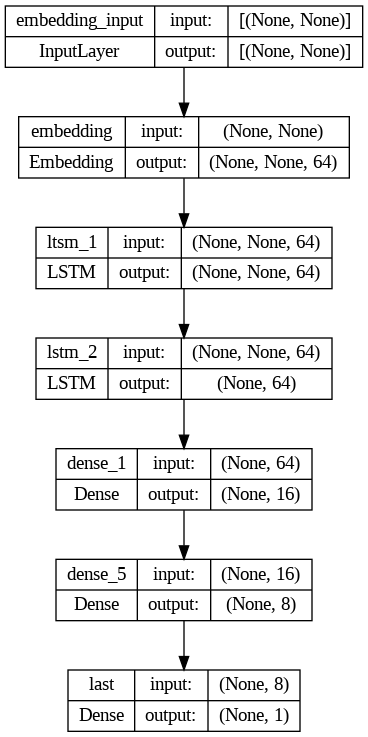

In [55]:
from keras.utils import plot_model
plot_model(model_lstm, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [56]:
optimizer= tf.keras.optimizers.Adam()

model_lstm.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [57]:
model_lstm.fit(train_set,
              epochs=100, 
              validation_data=val_set,
               class_weight=weights)

Epoch 1/100


ValueError: ignored

In [ ]:
model_lstm.save("model_lstm.h5")

In [ ]:
import json
json.dump(model_lstm.history.history, open("/content/LSTM_history.json", 'w'))

In [ ]:
LSTM_history = json.load(open("/content/LSTM_history.json", 'r'))
model_lstm = tf.keras.models.load_model("/content/model_lstm.h5")

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=LSTM_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=LSTM_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()


In [ ]:
score = model_lstm.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Binary Accuracy:", score[1])